%%latex
\begin{center}
\author{Cecily Abraham, Kelsey McDonald}
\end{center}

%%latex
\begin{abstract}
In this paper, we implement and optimize the sparse singular value decomposition (SSVD) algorithm proposed by Lee et al. (2010)$^1$, which is applied as a biclustering method. The SSVD algorithm obtains the singular vectors through regular singular value decomosition, and imposes sparsity-inducing regularization penalities on the least squares regression of the singular vectors in order to identify row-column associations within high-dimensional data. We convert Lee et al.'s publicly available Matlab code to Python and succesfully speed up the run time by a factor of 24. The optimized code successfully recreates the authors' output on the lung cancer gene expressions data set used in the original paper. We also compare the SSVD's performance to that of the Spectral Biclustering algorithm in Python's \texttt{sklearn} package on the genes data set and two simulated data sets. \\
KEY WORDS: Biclustering; Singular value decomposition; Sparcity; Optimization.
\end{abstract}

\section*{Background}

In the paper titled \underline{Biclustering via Sparse Singular Value Decomposition}, Lee et al. (2010) propose an exploratory data analysis tool for biclustering by way of a sparse singular value decomposition algorithm. Biclustering methods are one of many ways to identify structures in data, which they do by identifying sets of rows and columns in a matrix that are highly associated. Unsupervised learning methods like biclustering are able to explore high-dimensional low sample size (HDLSS) data where more classical statistical methods fail. HDLSS data are common in medical fields, particularly medical imaging and microarray gene expression data. In their paper, Lee et al. explore a data set of gene expressions relating to identifying groups of genes that have a significant association with different types of lung cancer. This is just one example of how biclustering has practical applications that have the potential to substantially influence medical care in a positive way.

\section*{Algorithm}

Sparse singular value decomposition takes the singular value decomposition (SVD) of a matrix, $\mathbf{X}$, which decomposes $X$ in the following way:
$$\mathbf{X} = \mathbf{U}\mathbf{D}\mathbf{V^{T}} = \sum_{k=1}^{r} s_k \mathbf{u_k} \mathbf{v_{k}^{T}}$$

where $\mathbf{U}= (\mathbf{u}_1, \dots , \mathbf{u}_r)$ and $\mathbf{V}= (\mathbf{v}_1, \dots , \mathbf{v}_r)$ are vectors of left and right orthonormal singular vectors, respectively.
 
\section*{Performance and Optimization}

\subsection*{Unoptimized Algorithm}

Initial implementation of the SSVD algorithm is fairly straightforward, as all it requires is converting the Matlab code provided by the authors to Python. The source code for this function (called \texttt{ssvd\_works}) is in the file \textit{ssvd\_original.py}, and the source code for the authors' Matlab function is in the file \textit{ssvd.m}.

To test the Python equivalent of the SSVD algorithm for speed and bottlenecks, we ran it on the genes data set. The data are available in the file \textit{data.txt}, and an explanation of its structure is included in the section titled \textbf{Comparison to Other Biclustering Algorithms}. The following code imports the data and saves it as $X$. 

In [17]:
#Import packages
import numpy as np
#Import slow algorithm, ssvd_work,s from ssvd_original.py source code
from ssvd_original import ssvd_works 
%load_ext line_profiler
#Load in genes data
X = np.loadtxt('data.txt')

In [2]:
%timeit -r1 -n1 [u,v,iters] = ssvd_works(X)

1 loop, best of 1: 19min 20s per loop


%%latex
The unoptimized code takes roughly 19 minutes on a Linux Intel® Core™ i7-5960X CPU @ 3.00GHz × 16 Processor. The line profiler shows that the slowest sections of the code are the parts that update $\mathbf{u}$ and $\mathbf{v}$.

%%latex
\subsection*{Optimized Algorithm}

To speed up the algorithm, we used the \texttt{jit} function from the \texttt{Numba} package and vectorization in \texttt{Numpy}. The parts of the algorithm that update $\mathbf{u}$ and $\mathbf{v}$ were rewritten. The original updates to $\mathbf{u}$ and $\mathbf{v}$ were done with vectorization, so we rewrote the matrix parts of those functions with double for loops so that \texttt{jit} could be applied to them. In order to use \texttt{jit}, they were made into separate functions, \texttt{updateU} and \texttt{updateV}. We also created the \texttt{gt} function to compare floats; this was optimized with \texttt{jit}. The \texttt{ssvd} function then calls the optimized helper functions. The \texttt{ssvd} function was optimized via vectorization in \texttt{Numpy}, replacing code such as \texttt{sum} and \texttt{abs} with \texttt{np.sum} and \texttt{np.abs}. The source code for these functions can be seen in the \textit{ssvd\_fast.py} file.

As shown in the code below, the optimized \texttt{ssvd} function takes roughly 40 seconds to run on the Processor, which is over 26 times faster than the original function.

In [4]:
#Import optimized algorithm, ssvd, from ssvd_fast.py source code file
from ssvd_fast import ssvd

In [5]:
%timeit -r1 -n1 [u,v,iters] = ssvd(X)

1 loop, best of 1: 43 s per loop


In [18]:
%lprun -s -f ssvd -T ssvd_results.txt ssvd(X)
%cat ssvd_results.txt


*** Profile printout saved to text file 'ssvd_results.txt'. 
Timer unit: 1e-06 s

Total time: 38.336 s
File: /home/krm58/Desktop/OneDrive/Documents/Duke/Statistics/Biclustering-SSVD/Biclustering-SSVD/ssvd_fast.py
Function: ssvd at line 63

Line #      Hits         Time  Per Hit   % Time  Line Contents
    63                                           def ssvd(X,param=None):
    64         1            7      7.0      0.0      n, d = X.shape
    65         1            4      4.0      0.0      threu = 1
    66         1            4      4.0      0.0      threv = 1
    67         1            3      3.0      0.0      gamu = 0
    68         1            3      3.0      0.0      gamv = 0
    69         1      9099755 9099755.0     23.7      t1, t2, t3 = np.linalg.svd(X)
    70         1            6      6.0      0.0      t3 = t3.T
    71         1            5      5.0      0.0      u0 = t1[:,0]
    72         1            2      2.0      0.0      v0 = t3[:,0]
    73         1          

%%latex
\section*{Comparison to Other Biclustering Algorithms}

In this section, we explore and compare the SSVD algorithm with the Spectral Biclustering algorithm from the \texttt{sklearn} package. We asses both algorithms' performance as biclustering methods on three data sets: the real gene expressions data set used by Lee et al., which is somewhat sparse by nature, a simulated non-sparse data set, and a simulated sparse data set.

\subsection*{Genes Data Set}

This data set, which the authors used to demonstrate the SSVD algorithm's success, contains 12,625 genes for 56 subjects with lung cancer. The input matrix is comprised of the 12,625 microarray gene expressions. The goal of research of this nature is to identify if there are associations between particular genes and certain cancer types.

A recreation of a plot included in Lee et al., which displays the rank-one SSVD results on the genes matrix, is below.

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

In [7]:
#Rank-one biclustering of genes data with SSVD
[u1,v1,iters] = ssvd(X)

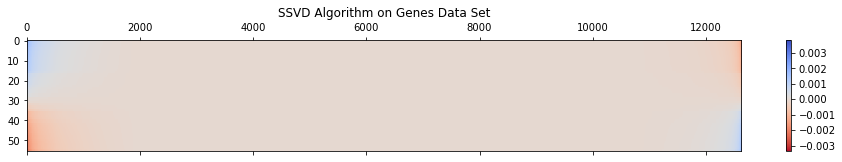

In [8]:
Xstar1 = np.outer(u1, v1.T)
X = X-Xstar1
v1sort = np.sort(v1)[::-1] #sort descending
u1sort = np.sort(u1)[::-1] #sort descending
x = np.outer(u1sort, v1sort.T)
x = x/np.max(np.abs(X))
plt.matshow(x.T, cmap=plt.cm.coolwarm_r, aspect='auto');
plt.colorbar()
plt.title('SSVD Algorithm on Genes Data Set', y=1.15)
pass

%%latex
The visible concentration of red and blue in the corners of the plot indicates that the optimized SSVD algorithm has successfully biclustered the genes matrix.

We continue by running \texttt{sklearn's} Spectral Biclustering algorithm on the genes data and creating an analogous rank-one plot.

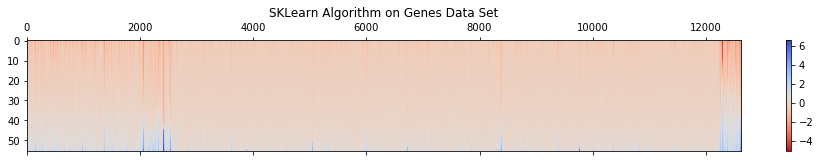

In [9]:
#Rank-one biclustering of genes data with Spectral Biclustering
model = SpectralBiclustering(n_clusters=4, method='log',
                             random_state=0)
model.fit(X)
fit_data = X[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
fit_data = np.sort(fit_data)
plt.matshow(fit_data.T, cmap=plt.cm.coolwarm_r, aspect='auto');
plt.colorbar()
plt.title('SKLearn Algorithm on Genes Data Set', y=1.15)
pass

%%latex
The plot above has slight concentrations of red and blue on the right side but is much more uniform in color than the SSVD plot. This reveals that the Spectral Biclustering algorithm is only somewhat successful. Comparing the two algorithms on the somewhat sparse genes data set, we can see that the SSVD algorithm reveals more structure on a rank-one pass than does the Spectral Biclustering algorithm. This is due to the sparse nature of the data set.

\subsection*{Simulated Non-Sparse Data Set}

We employ the \texttt{make\_checkerboard} function from \texttt{sklearn} to generate a non-sparse data set. The \texttt{sklearn} documentation$^2$ provides a brief explanation on how to generate a checkerboard data set and bicluster it using the Spectral Biclustering algorithm: "The data is generated with the \texttt{make\_checkerboard} function, then shuffled and passed to the Spectral Biclustering algorithm. The rows and columns of the shuffled matrix are rearranged to show the biclusters found by the algorithm. The outer product of the row and column label vectors shows a representation of the checkerboard structure." The code to generate the data, bilcuster it, and produce the checkerboard plots comes from the same \texttt{sklearn} documentation$^2$.

The following code generates a non-sparse data set. If the algorithm is successful, the first and third plots will both have a $4 \times 4$ checkerboard structure.

In [10]:
#Make simulated data with a checkerboard structure
n_clusters = (2, 2)
data, rows, columns = make_checkerboard(
    shape=(12000, 60), n_clusters=n_clusters, noise=4,
    shuffle=False, random_state=0)

%%latex
We implement the SSVD algorithm on the non-sparse matrix to asses its ability to bicluster when there is a lack of sparcity.

In [11]:
#Implement SSVD algorithm on non-sparse synthesized data
[u1,v1,iters] = ssvd(data)

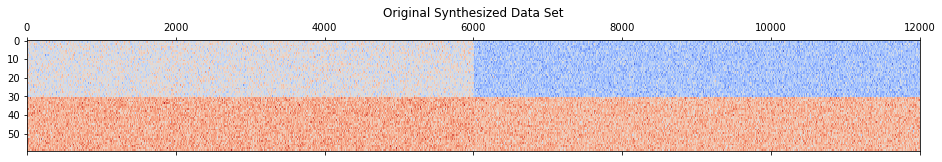

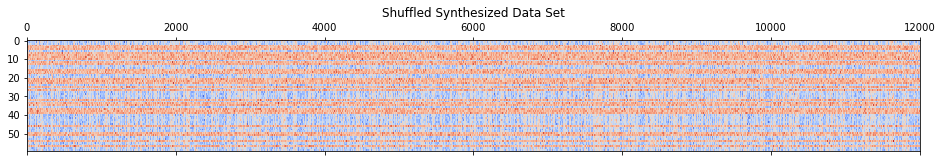

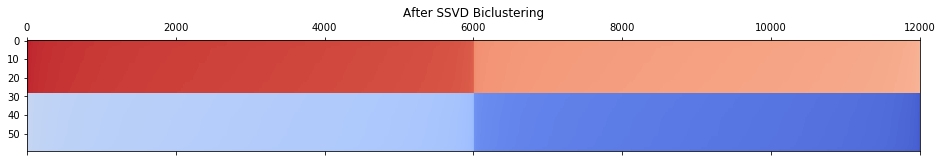

In [12]:
Xstar1 = np.outer(u1, v1.T)
X = data-Xstar1
xmax = np.max(np.abs(X))
v1sort = np.sort(v1)[::-1] #sort descending
u1sort = np.sort(u1)[::-1] #sort descending
x = np.outer(u1sort, v1sort.T)
xfake = x/xmax
#Plots
plt.matshow(data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Original Synthesized Data Set", y=1.15)

#Shuffled data
datashuff, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(datashuff.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Shuffled Synthesized Data Set", y=1.15)

plt.matshow(xfake.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("After SSVD Biclustering", y=1.15)
pass

%%latex
The "After SSVD Biclustering" plot has the desired checkerboard pattern. Therefore, the SSVD algorithm is able to recover the number of biclusters that were originally used to create the synthesized data set.

Now we test the Spectral Biclustering algorithm on the same non-sparse synthesized data.

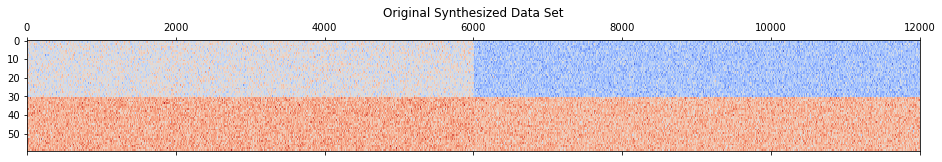

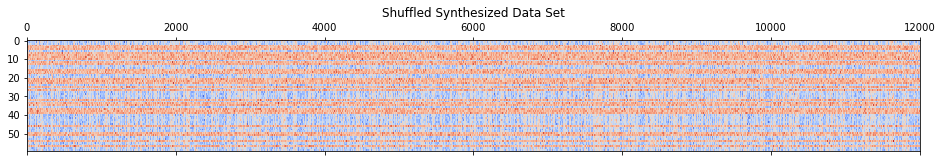

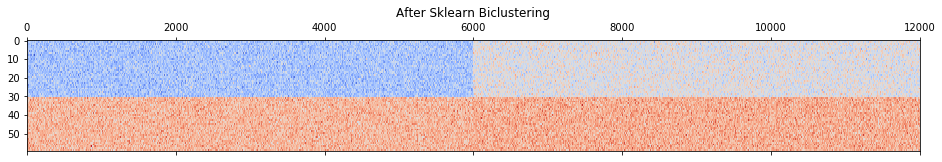

In [13]:
plt.matshow(data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Original Synthesized Data Set", y=1.15)

#Shuffled data
datashuff, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(datashuff.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Shuffled Synthesized Data Set", y=1.15)

#Spectral Biclustering on synthesized data
model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(datashuff)

fit_data = datashuff[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("After Sklearn Biclustering", y=1.15)
pass

%%latex
The checkerboard returned by the Spectral Biclustering algorithm demonstrates that it is also able to recover the bilcusters after the data are shuffled. Based on these results, the SSVD algorithm and \texttt{sklearn's} Spectral Biclustering algorithm are comparable when the input matrix is non-sparse.

\subsection*{Simulated Sparse Data Set}

We want to compare biclustering performance on sparse data, so, because the genes data are not specifically sparse, we are making a second synthetic data set with sparcity. This synthetic data set is described in Lee et al.'s supplemental$^3$ material, which is the \textit{LeeShenHuangMarron09-sup.pdf} file on Github. The simplest example to generate a sparse matrix is to create a $100 \times 50$ ground truth matrix, $X^*$, where every non-zero element is the same, and therefore is equally likely to be chosen by a sparse procedure. The following code generates the sparse matrix and runs both algorithms on it as we did with the previous two data sets.

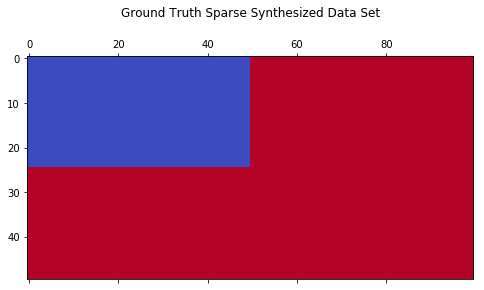

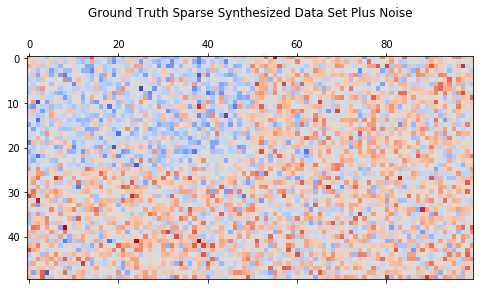

In [14]:
#u is a unit vector of length 100
#with ui = 1/√50 for i = 1,...,50, and ui = 0 otherwise
ufirst = (1/np.sqrt(50))*np.ones((50,1))
ulast = np.zeros((50,1))
u = np.hstack((ufirst.flatten(), ulast.flatten()))

#v is a unit vector of length 50
#with vj = 1/5 for j = 1,...,25, and vj = 0 otherwise.
vfirst = (1/5)*np.ones((25,1))
vlast = np.zeros((25,1))
v = np.hstack((vfirst.flatten(), vlast.flatten()))

#X* = suvT is a rank one matrix with uniform nonzero entries
#s is set to 30
s = 30
Xstar = s*np.outer(u, v.T)
noise = np.random.standard_normal(size=Xstar.shape)

#The input matrix X is the summation of the true signal, Xstar
#and noise from the standard normal distribution
X = Xstar + noise

#Plots
plt.matshow(Xstar.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Ground Truth Sparse Synthesized Data Set", y=1.15)

plt.matshow(X.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Ground Truth Sparse Synthesized Data Set Plus Noise",
          y=1.15)
pass

%%latex
Notice how the blue rectangle in the upper left corner is still identifiable after adding noise. Now we shuffle the data and attempt to bicluster it with the SSVD.

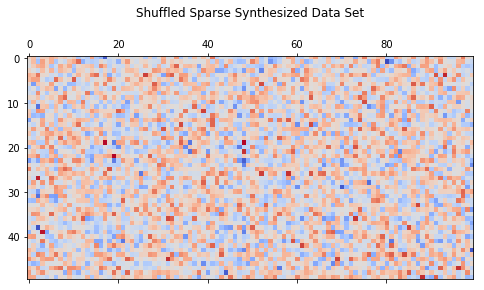

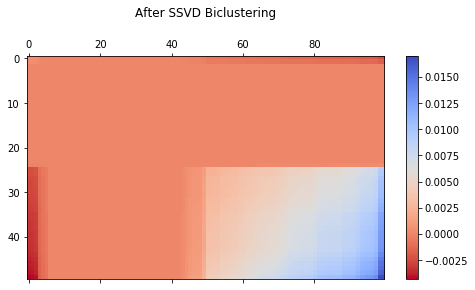

In [15]:
#Shuffled data
datashuff, row_idx, col_idx = sg._shuffle(X, random_state=0)
plt.matshow(datashuff.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Shuffled Sparse Synthesized Data Set", y=1.15)

#Implement SSVD algorithm on synthesized sparse data
[u1,v1,iters] = ssvd(datashuff)
Xstar1 = np.outer(u1, v1.T)
Xbi = X-Xstar1
xmax = np.max(np.abs(Xbi))
v1sort = np.sort(v1)[::-1] #sort descending
u1sort = np.sort(u1)[::-1] #sort descending
x = np.outer(u1sort, v1sort.T)
Xbi = x/xmax

plt.matshow(Xbi.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("After SSVD Biclustering", y=1.15)
plt.colorbar()
pass

%%latex
The plot directly above displays the recovered biclustering. Thus, our SSVD algorithm can recover the biclustering of a sparse, synthesized data set when we know the ground truth.

The last step is to try to recover the biclusters via Spectral Biclustering.

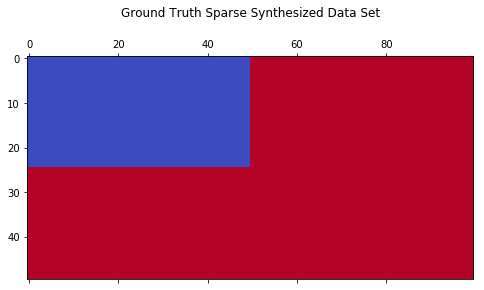

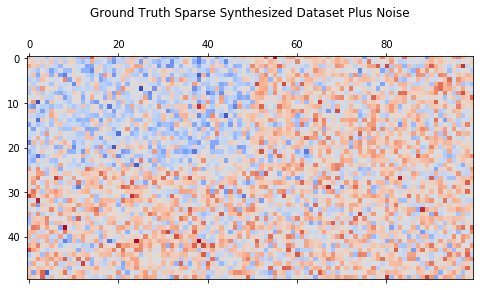

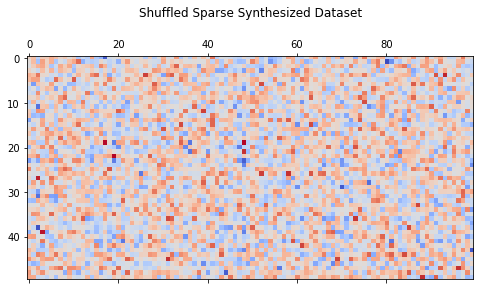

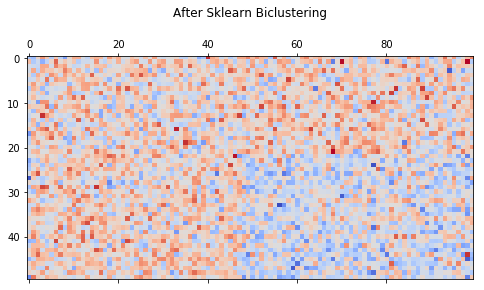

In [16]:
#Plots
plt.matshow(Xstar.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Ground Truth Sparse Synthesized Data Set", y=1.15)

plt.matshow(X.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Ground Truth Sparse Synthesized Dataset Plus Noise",
          y=1.15)

datashuff, row_idx, col_idx = sg._shuffle(X, random_state=0)
plt.matshow(datashuff.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Shuffled Sparse Synthesized Dataset", y=1.15)

#Run Spectral Biclustering
model = SpectralBiclustering(n_clusters=2, method='log',
                             random_state=0)
model.fit(datashuff)

fit_data = datashuff[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("After Sklearn Biclustering", y=1.15)
pass

%%latex
The fuzzy yet identifiable blue rectangle in the bottom left corner conveys that the Spectral Biclustering algorithm is mildly successful in recovering the biclustering, but it underperforms visually compared to the SSVD algorithm when the data are sparse.

\section*{Conclusion}

Lee et al. present an alternative method for biclustering that we have optimized to improve its practicality. The results of the performance testing demonstrate that the SSVD algorithm is comparable to the Spectral Biclustering algorithm when the input matrix is non-sparse, but it outperforms the Spectral algorithm at an increasing rate as the sparcity of the matrix increases. The SSVD has the potential to enhance research and contribute to new sample/variable associations in sparse data, particularly in the medical imaging and gene expression analysis.

%%latex
\section*{References}

[1] Lee, M., Shen, H., Huang, J., and Marron, J. (2010), “Biclustering via Sparse Singular Value Decomposition,” Biometrics, 66, 1087–1095.

[2] http://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py

[3] Lee, M., Shen, H., Huang, J., and Marron, J. (2009), https://www.stat.tamu.edu/~jianhua/paper/LeeShenHuangMarron09-sup.pdf